In [1]:
config_path = r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3\config.yaml"
import cv2
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import yaml
import datetime

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
def get_config(config_path:str) :
    with open(config_path, 'r') as ymlfile:
        cfg = yaml.load(ymlfile)
    return cfg

_config = get_config(config_path)

os.chdir(_config["cars-image-path"])
fileNames = glob.glob("*/*.pgm")
target=[]
for fileName in fileNames:
    if fileName.find("neg") > 0:
        target.append(0)
    else:
        target.append(1)
#Delete image *neg-130.pgm because it somehow throws errors during processing
for i in range(0, len(fileNames)):
    if fileNames[i].find('neg-130') > 0:
        toDelete = i
fileNames.pop(toDelete)
target.pop(toDelete)
X_train, X_test, y_train, y_test = train_test_split(fileNames, target, random_state=43)

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
#sift = cv2.ORB_create()
sift = cv2.xfeatures2d.SIFT_create()
dico = []
for fileName in X_train:
    img = cv2.imread(os.path.join(_config["cars-image-path"], fileName))
    kp, des = sift.detectAndCompute(img, None)
    for d in des:
        dico.append(d)

In [4]:
k = 700
batch_size = 6
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

Init 1/3 with method: k-means++
Inertia for init 1/3: 0.000000
Init 2/3 with method: k-means++
Inertia for init 2/3: 0.000000
Init 3/3 with method: k-means++
Inertia for init 3/3: 0.000000
Minibatch iteration 1/2137200: mean batch inertia: 122525.666667, ewa inertia: 122525.666667 
Minibatch iteration 2/2137200: mean batch inertia: 119320.833333, ewa inertia: 122525.366755 
Minibatch iteration 3/2137200: mean batch inertia: 118891.000000, ewa inertia: 122525.026647 
Minibatch iteration 4/2137200: mean batch inertia: 94514.000000, ewa inertia: 122522.405344 
Minibatch iteration 5/2137200: mean batch inertia: 124287.500000, ewa inertia: 122522.570523 
Minibatch iteration 6/2137200: mean batch inertia: 79244.833333, ewa inertia: 122518.520544 
Minibatch iteration 7/2137200: mean batch inertia: 111681.833333, ewa inertia: 122517.506435 
Minibatch iteration 8/2137200: mean batch inertia: 121553.500000, ewa inertia: 122517.416222 
Minibatch iteration 9/2137200: mean batch inertia: 120113.833

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=18 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=18 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=18 should be larger than k=700. Setting it to 3*k
  init_size=init_size)


In [5]:
kmeans.verbose = False
histo_list = []
for fileName in X_train:
    img = cv2.imread(os.path.join(_config["cars-image-path"], fileName))
    kp, des = sift.detectAndCompute(img, None)
    histo = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefer to add 1/nkp directly
    histo_list.append(histo)    

In [6]:
X = np.array(histo_list)

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
predictions = []
xes_test = []
for fileName in X_test:
    img = cv2.imread(os.path.join(_config["cars-image-path"], fileName))
    kp, des = sift.detectAndCompute(img, None)
    x = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp
    #res = clf.predict_proba([x])
    predictions.append(clf.predict([x]))
    xes_test.append(x)
    

In [8]:
XX = X.copy()
XX = np.concatenate((XX, np.array(xes_test)))
YY = np.concatenate((y_train, y_test))

In [9]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
rfclf_param_grid = {
  "n_estimators": [100, 300, 500],
  "max_depth": [5, 7, None],
  "max_features": [5, "auto"],
  }
rfclf = RandomForestClassifier()
rfclf_grid_search = GridSearchCV(rfclf, param_grid=rfclf_param_grid, cv=10, n_jobs=1)
rfclf_grid_search.fit(XX, YY)

report(rfclf_grid_search.cv_results_) 

df_gr = pd.DataFrame(rfclf_grid_search.cv_results_)
df_gr = df_gr[['mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score', 'param_max_depth', 'param_max_features', 'param_n_estimators']]
df_gr.index.name = 'id'
df_gr = df_gr.round(4)
df_gr.to_csv('grid_rfr_cars_sift.csv', sep=';', float_format='%.4f') 

Model with rank: 1
Mean validation score: 0.941 (std: 0.010)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.938 (std: 0.017)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.937 (std: 0.017)
Parameters: {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}



In [10]:
mlpclf_param_grid = {"hidden_layer_sizes": [(30,), (100,), (100,30)], #, (30, 30, 20), smaller ones e.g. 10; 15; 15,15 worse
              "activation": [ "relu"], #tanh worse
              "solver": ["adam"], #lbfgs worse
              "alpha": [0.0001, 0.001, 0.03], #0.0001, 0.005, 
              "max_iter": [200, 500]} # 100, 200 worse, does not converge
mlpclf = MLPClassifier()
mlpclf_grid_search = GridSearchCV(mlpclf, param_grid=mlpclf_param_grid, cv=10, n_jobs=1)
mlpclf_grid_search.fit(XX, YY)

report(mlpclf_grid_search.cv_results_) 

df_grm = pd.DataFrame(mlpclf_grid_search.cv_results_)
df_grm = df_grm[['mean_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score', 'param_hidden_layer_sizes', 'param_alpha', 'param_max_iter']]
df_grm.index.name = 'id'
df_grm = df_grm.round(4)
df_grm.to_csv('grid_mlp_cars_sift.csv', sep=';', float_format='%.4f')

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_net

Model with rank: 1
Mean validation score: 0.839 (std: 0.024)
Parameters: {'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (100,), 'max_iter': 500, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.838 (std: 0.028)
Parameters: {'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (30,), 'max_iter': 200, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.835 (std: 0.026)
Parameters: {'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (30,), 'max_iter': 500, 'solver': 'adam'}



In [11]:
classifiers = [("Kneighbors", KNeighborsClassifier()),
               ('GaussianNB', GaussianNB()), 
               ('RandomForest', RandomForestClassifier()),
               ('RandomForest_OPT', RandomForestClassifier(n_estimators=300)),
               ('SVC', SVC()),
               ('MLP', MLPClassifier()),
               ('MLP_OPT', MLPClassifier(alpha=0.03, max_iter=500))
              ]
arr = []
times=[]
for classifier_tuple in classifiers:
    print(classifier_tuple[0]) 
    start = datetime.datetime.now()
    scores = cross_val_score(classifier_tuple[1], XX, YY, cv=10)
    #print(cross_val_score(classifier, train, target, cv=3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    arr.append(scores.mean())
    times.append((datetime.datetime.now() - start).seconds)
    
    Xp_train, Xp_test, yp_train, yp_test =  train_test_split(XX, YY, random_state=42)
    classifier_tuple[1].fit(Xp_train, yp_train)
    yp_pred = classifier_tuple[1].predict(Xp_test)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
    plt.rcParams.update({'font.size': 13})
    cm = confusion_matrix(yp_test, yp_pred)
    df_cm = pd.DataFrame(cm, index=["negative", "positive"], columns=["negative", "positive"])
    g = sns.heatmap(df_cm, annot=True,ax=ax)
    a = plt.title('Confusion Matrix of ' + classifier_tuple[0] + ' (Accuracy: ' + "{:.2f}".format(scores.mean()) + ')')
    g.get_figure().savefig(os.path.join(_config["plot-path"],'plots','cm_car_sift_' + classifier_tuple[0] + "_{:.0f}".format(scores.mean()*100)+'.png'))
    plt.close()

Kneighbors
Accuracy: 0.63 (+/- 0.01)
GaussianNB
Accuracy: 0.73 (+/- 0.06)
RandomForest
Accuracy: 0.90 (+/- 0.05)
RandomForest_OPT
Accuracy: 0.94 (+/- 0.03)
SVC
Accuracy: 0.62 (+/- 0.00)
MLP
Accuracy: 0.83 (+/- 0.05)
MLP_OPT
Accuracy: 0.84 (+/- 0.05)


c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators wil

In [12]:
classifier_names = [clf_tuple[0] for clf_tuple in classifiers]
df = pd.DataFrame(data=arr,columns=['accuracy'])
df['classifier'] = classifier_names
df['runtime'] = times

Text(0.5, 1.0, 'Performance by classifier')

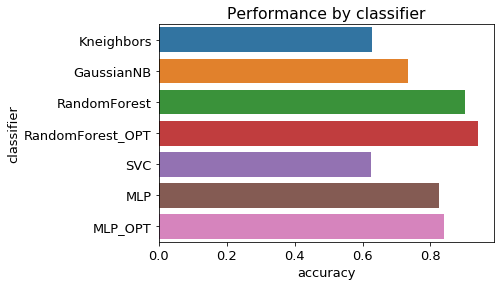

In [13]:
sns.barplot(x="accuracy", y="classifier", data=df)
plt.title('Performance by classifier')

Text(0.5, 1.0, 'Runtime by classifier')

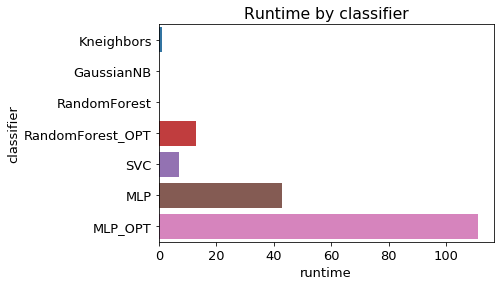

In [14]:
sns.barplot(x="runtime", y="classifier", data=df)
plt.title('Runtime by classifier')